# Imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
import warnings
from tables import NaturalNameWarning
warnings.filterwarnings('ignore', category=NaturalNameWarning)

# Data Aquisition:

In [2]:
hdf = pd.HDFStore('data.h5')

temp = pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]})

hdf.put('Mason', temp)
hdf.put('Amy', temp)
hdf.put('Connor', temp)

# display hf structure 
def h5_tree(val, pre=''):
    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if type(val) == h5py._hl.group.Group:
                print(pre + '└── ' + key)
                h5_tree(val, pre+'    ')
            else:
                print(pre + '└── ' + key + ' (%d)' % len(val))
        else:
            if type(val) == h5py._hl.group.Group:
                print(pre + '├── ' + key)
                h5_tree(val, pre+'│   ')
            else:
                print(pre + '├── ' + key + ' (%d)' % len(val))



jumping_df = pd.DataFrame
jumping_files = ['mason-jumping-1.csv', 'Carter_jumping.csv']
for file in jumping_files:
    temp = pd.read_csv(file)
    if jumping_df.empty:
        jumping_df = temp
    else:
        jumping_df = pd.concat([jumping_df, temp])

walking_df = pd.DataFrame
walking_files = ['mason-walking-1.csv', 'Carter_walking.csv']
for file in walking_files:
    temp = pd.read_csv(file)
    if walking_df.empty:
        walking_df = temp
        # delete first and last 2 seconds of data
        walking_df = walking_df.drop(walking_df.index[0:200])
        walking_df = walking_df.drop(walking_df.index[-200:])
    else:
        # delete first and last 2 seconds of data
        temp = temp.drop(temp.index[0:200])
        temp = temp.drop(temp.index[-200:])
        walking_df = pd.concat([walking_df, temp])


# add labels
walking_df['class'] = 0
jumping_df['class'] = 1

# combine dataframes
df = pd.concat([walking_df, jumping_df], ignore_index=True)

# replace column names
df.columns = ['Time', 'Accel X', 'Accel Y', 'Accel Z', 'Absolute Accel', 'Class']

hdf.put('data', df, format='table', data_columns=True)

print(hdf.keys())
# close hdf file
hdf.close()


['/Amy', '/Connor', '/Mason', '/data']


# Visualization:

       Time   Accel X   Accel Y   Accel Z  Absolute Accel  Class
0  1.093852 -5.672278  0.300588  1.979976        6.015430      0
1  1.098800 -5.491416  0.280305  2.785333        6.163789      0
2  1.103748 -5.470981  0.436641  3.400820        6.456614      0
3  1.108697 -5.621639  0.595874  3.753166        6.785584      0
4  1.113645 -5.909056  0.762246  3.833645        7.084828      0


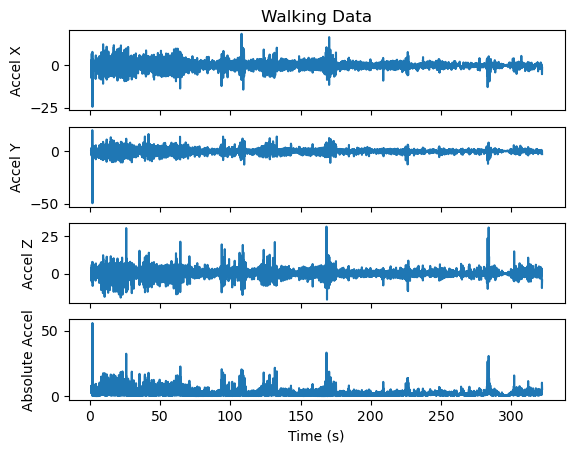

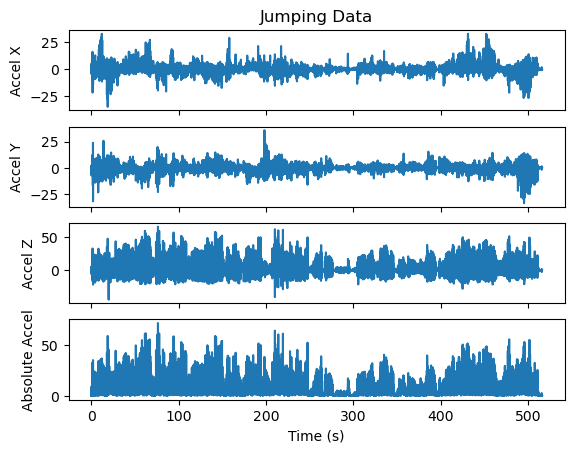

In [3]:
# array columns: Time, Accel X, Accel Y, Accel Z, Absolute Accel Class
# array rows: 1 row per 5 seconds of data
# walking class is 0
# jumping class is 1

df = pd.read_hdf('data.h5', 'data')
print(df.head())


# plot walking data
walking_df = df[df['Class'] == 0]
walking_df = walking_df.reset_index(drop=True)
walking_df = walking_df.drop(['Class'], axis=1)
axis, fig = plt.subplots(4, sharex=True)
fig[0].plot(walking_df['Time'], walking_df['Accel X'])
fig[0].set_ylabel('Accel X') 
fig[0].set_title('Walking Data')
fig[1].plot(walking_df['Time'], walking_df['Accel Y'])
fig[1].set_ylabel('Accel Y')
fig[2].plot(walking_df['Time'], walking_df['Accel Z'])
fig[2].set_ylabel('Accel Z')
fig[3].plot(walking_df['Time'], walking_df['Absolute Accel'])
fig[3].set_ylabel('Absolute Accel')
fig[3].set_xlabel('Time (s)')


# plot jumping data
jumping_df = df[df['Class'] == 1]
jumping_df = jumping_df.reset_index(drop=True)
jumping_df = jumping_df.drop(['Class'], axis=1)
axis1, fig1 = plt.subplots(4, sharex=True)
fig1[0].plot(jumping_df['Time'], jumping_df['Accel X'])
fig1[0].set_ylabel('Accel X')
fig1[0].set_title('Jumping Data')
fig1[1].plot(jumping_df['Time'], jumping_df['Accel Y'])
fig1[1].set_ylabel('Accel Y')
fig1[2].plot(jumping_df['Time'], jumping_df['Accel Z'])
fig1[2].set_ylabel('Accel Z')
fig1[3].plot(jumping_df['Time'], jumping_df['Absolute Accel'])
fig1[3].set_ylabel('Absolute Accel')
fig1[3].set_xlabel('Time (s)')

plt.show()

# Preprocessing:

In [4]:
df = pd.read_hdf('data.h5', 'data')
rows_per_chunk = int(round(5/(df['Time'][1]-df['Time'][0])))


# split data by class
walking_df = df[df['Class'] == 0]
walking_df = walking_df.reset_index(drop=True)
walking_df = walking_df.drop(['Class'], axis=1)

jumping_df = df[df['Class'] == 1]
jumping_df = jumping_df.reset_index(drop=True)
jumping_df = jumping_df.drop(['Class'], axis=1)


# remove outliers that are more than 3 standard deviations from the mean
walking_df = walking_df[(np.abs(walking_df['Absolute Accel']-walking_df['Absolute Accel'].mean()) <= (3*walking_df['Absolute Accel'].std()))]
jumping_df = jumping_df[(np.abs(jumping_df['Absolute Accel']-jumping_df['Absolute Accel'].mean()) <= (3*jumping_df['Absolute Accel'].std()))]


# split data into 5 second chunks and flatten each chunk into a single row
flat_walking = None
for i in range(0, len(walking_df), rows_per_chunk):
    if flat_walking is None:
        flat_walking = walking_df.iloc[i:i+rows_per_chunk].values.flatten()
    else:
        try:
            flat_walking = np.vstack([flat_walking, walking_df.iloc[i:i+rows_per_chunk].values.flatten()])
        except:
            pass

flat_jumping = None
for i in range(0, len(jumping_df), rows_per_chunk):
    if flat_jumping is None:
        flat_jumping = jumping_df.iloc[i:i+rows_per_chunk].values.flatten()
    else:
        try:
            flat_jumping = np.vstack([flat_jumping, jumping_df.iloc[i:i+rows_per_chunk].values.flatten()])
        except:
            pass

print(flat_walking.shape)
print(flat_walking[0][:10])

(75, 5050)
[ 1.09385182 -5.6722784   0.30058789  1.9799757   6.01543009  1.09880005
 -5.49141598  0.28030491  2.78533292  6.1637894 ]


Feature Extraction:

In [29]:
# TODO find maximum, minimum, range, mean, median, variance, skewness, kurtosis, and standard deviation for each column
# convert to pandas dataframe
walking_df = pd.DataFrame(flat_walking)
jumping_df = pd.DataFrame(flat_jumping)
print(walking_df.columns)


temp = pd.DataFrame()
for index, row in walking_df.iterrows():
    arr = row.to_numpy()
    # reshape to have 5 columns
    arr = arr.reshape(5, int(len(arr)/5))
    df = pd.DataFrame(arr)
    # find max, min, range, mean, median, variance, skewness, kurtosis, and standard deviation for each column
    new_attributes = pd.DataFrame(columns=['Max Accel X', 'Min Accel X', 'Range Accel X', 'Mean Accel X', 'Median Accel X', 'Variance Accel X', 'Skewness Accel X', 'Kurtosis Accel X', 'Max Accel Y', 'Min Accel Y', 'Range Accel Y', 'Mean Accel Y', 'Median Accel Y', 'Variance Accel Y', 'Skewness Accel Y', 'Kurtosis Accel Y', 'Max Accel Z', 'Min Accel Z', 'Range Accel Z', 'Mean Accel Z', 'Median Accel Z', 'Variance Accel Z', 'Skewness Accel Z', 'Kurtosis Accel Z', 'Max Absolute Accel', 'Min Absolute Accel', 'Range Absolute Accel', 'Mean Absolute Accel', 'Median Absolute Accel', 'Variance Absolute Accel', 'Skewness Absolute Accel', 'Kurtosis Absolute Accel'])
    new_attributes['Max Accel X'][0] = df[1].max()
    new_attributes['Min Accel X'] = df[1].min()
    new_attributes['Range Accel X'] = df[1].max()-df[1].min()
    new_attributes['Mean Accel X'] = df[1].mean()
    new_attributes['Median Accel X'] = df[1].median()
    new_attributes['Variance Accel X'] = df[1].var()
    new_attributes['Skewness Accel X'] = df[1].skew()
    new_attributes['Kurtosis Accel X'] = df[1].kurtosis()
    new_attributes['Max Accel Y'] = df[2].max()
    new_attributes['Min Accel Y'] = df[2].min()
    new_attributes['Range Accel Y'] = df[2].max()-df[2].min()
    new_attributes['Mean Accel Y'] = df[2].mean()
    new_attributes['Median Accel Y'] = df[2].median()
    new_attributes['Variance Accel Y'] = df[2].var()
    new_attributes['Skewness Accel Y'] = df[2].skew()
    new_attributes['Kurtosis Accel Y'] = df[2].kurtosis()
    new_attributes['Max Accel Z'] = df[3].max()
    new_attributes['Min Accel Z'] = df[3].min()
    new_attributes['Range Accel Z'] = df[3].max()-df[3].min()
    new_attributes['Mean Accel Z'] = df[3].mean()
    new_attributes['Median Accel Z'] = df[3].median()
    new_attributes['Variance Accel Z'] = df[3].var()
    new_attributes['Skewness Accel Z'] = df[3].skew()
    new_attributes['Kurtosis Accel Z'] = df[3].kurtosis()
    new_attributes['Max Absolute Accel'] = df[4].max()
    new_attributes['Min Absolute Accel'] = df[4].min()
    new_attributes['Range Absolute Accel'] = df[4].max()-df[4].min()
    new_attributes['Mean Absolute Accel'] = df[4].mean()
    new_attributes['Median Absolute Accel'] = df[4].median()
    new_attributes['Variance Absolute Accel'] = df[4].var()
    new_attributes['Skewness Absolute Accel'] = df[4].skew()
    new_attributes['Kurtosis Absolute Accel'] = df[4].kurtosis()
    
    print(new_attributes)
    # add new attributes to temp dataframe
    if temp.empty:
        temp = new_attributes
    else:
        temp = pd.concat([temp, new_attributes], axis=0)
# add temp to walking_df
walking_df = pd.concat([walking_df, temp], axis=1)


temp = pd.DataFrame()
for index, row in jumping_df.iterrows():
    arr = row.to_numpy()
    # reshape to have 5 columns
    arr = arr.reshape(5, int(len(arr)/5))
    df = pd.DataFrame(arr)
    # find max, min, range, mean, median, variance, skewness, kurtosis, and standard deviation for each column
    new_attributes = pd.DataFrame()
    new_attributes['Max Accel X'] = df[1].max()
    new_attributes['Min Accel X'] = df[1].min()
    new_attributes['Range Accel X'] = df[1].max()-df[1].min()
    new_attributes['Mean Accel X'] = df[1].mean()
    new_attributes['Median Accel X'] = df[1].median()
    new_attributes['Variance Accel X'] = df[1].var()
    new_attributes['Skewness Accel X'] = df[1].skew()
    new_attributes['Kurtosis Accel X'] = df[1].kurtosis()
    new_attributes['Max Accel Y'] = df[2].max()
    new_attributes['Min Accel Y'] = df[2].min()
    new_attributes['Range Accel Y'] = df[2].max()-df[2].min()
    new_attributes['Mean Accel Y'] = df[2].mean()
    new_attributes['Median Accel Y'] = df[2].median()
    new_attributes['Variance Accel Y'] = df[2].var()
    new_attributes['Skewness Accel Y'] = df[2].skew()
    new_attributes['Kurtosis Accel Y'] = df[2].kurtosis()
    new_attributes['Max Accel Z'] = df[3].max()
    new_attributes['Min Accel Z'] = df[3].min()
    new_attributes['Range Accel Z'] = df[3].max()-df[3].min()
    new_attributes['Mean Accel Z'] = df[3].mean()
    new_attributes['Median Accel Z'] = df[3].median()
    new_attributes['Variance Accel Z'] = df[3].var()
    new_attributes['Skewness Accel Z'] = df[3].skew()
    new_attributes['Kurtosis Accel Z'] = df[3].kurtosis()
    new_attributes['Max Absolute Accel'] = df[4].max()
    new_attributes['Min Absolute Accel'] = df[4].min()
    new_attributes['Range Absolute Accel'] = df[4].max()-df[4].min()
    new_attributes['Mean Absolute Accel'] = df[4].mean()
    new_attributes['Median Absolute Accel'] = df[4].median()
    new_attributes['Variance Absolute Accel'] = df[4].var()
    new_attributes['Skewness Absolute Accel'] = df[4].skew()
    new_attributes['Kurtosis Absolute Accel'] = df[4].kurtosis()

    # add new attributes to temp dataframe
    if temp.empty:
        temp = new_attributes
    else:
        temp = pd.concat([temp, new_attributes], axis=0)

# add temp to jumping_df
jumping_df = pd.concat([jumping_df, temp], axis=1)

RangeIndex(start=0, stop=5050, step=1)


IndexError: index 0 is out of bounds for axis 0 with size 0

           0         1         2         3         4          5         6  \
0   1.093852 -5.672278  0.300588  1.979976  6.015430   1.098800 -5.491416   
1   6.274640  0.292811 -1.912537 -1.650014  2.542849   6.279588  0.325664   
2  11.757255  1.552836  4.200620  3.562294  5.722451  11.762203  1.630403   
3  17.422936 -0.289399  0.997865  1.055789  1.481275  17.427884 -0.187849   
4  23.034190 -1.169901  0.054993  1.718106  2.079322  23.039138 -1.687964   

          7         8         9  ...  Skewness Accel Z  Kurtosis Accel Z  \
0  0.280305  2.785333  6.163789  ...               NaN               NaN   
1 -1.771187 -1.522998  2.358534  ...               NaN               NaN   
2  4.273840  3.494936  5.756605  ...               NaN               NaN   
3  1.288898  1.032239  1.661946  ...               NaN               NaN   
4  0.213413  1.542317  2.296413  ...               NaN               NaN   

   Max Absolute Accel  Min Absolute Accel  Range Absolute Accel  \
0            

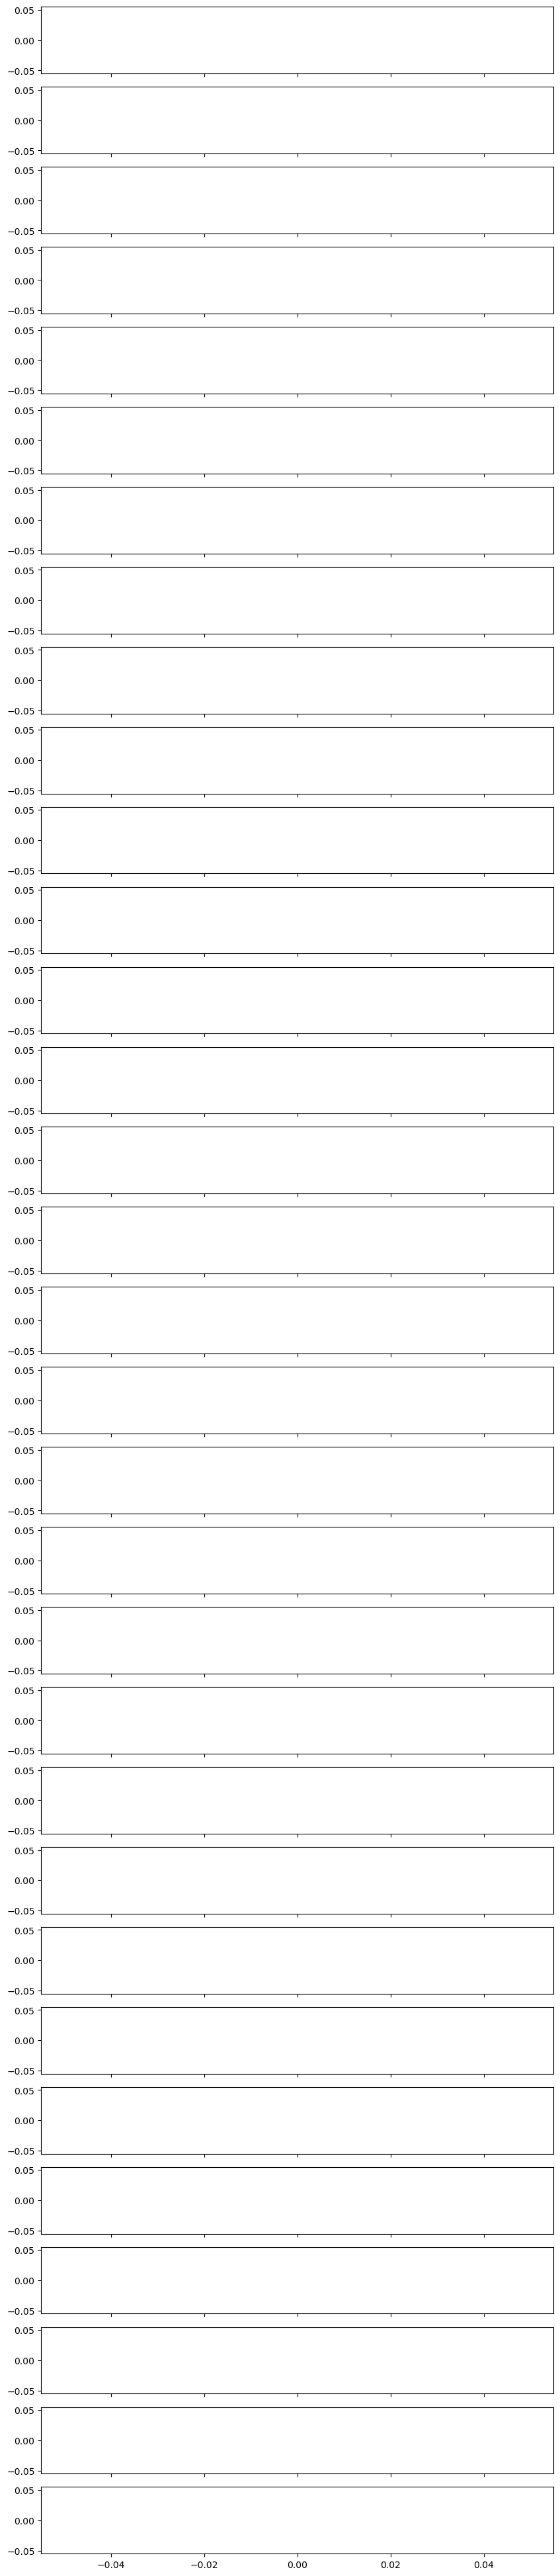

In [23]:
# plot max, min, range, mean, median, variance, skewness, kurtosis, and standard deviation
print(walking_df.head())
fig1, ax1 = plt.subplots(32, sharex=True, figsize=(10, 50))
ax1[0].scatter(walking_df[0], walking_df['Max Accel X'], label='Max Accel X')
ax1[1].scatter(walking_df[0], walking_df['Min Accel X'], label='Min Accel X')
ax1[2].scatter(walking_df[0], walking_df['Range Accel X'], label='Range Accel X')
ax1[3].scatter(walking_df[0], walking_df['Mean Accel X'], label='Mean Accel X')
ax1[4].scatter(walking_df[0], walking_df['Median Accel X'], label='Median Accel X')
ax1[5].scatter(walking_df[0], walking_df['Variance Accel X'], label='Variance Accel X')
ax1[6].scatter(walking_df[0], walking_df['Skewness Accel X'], label='Skewness Accel X')
ax1[7].scatter(walking_df[0], walking_df['Kurtosis Accel X'], label='Kurtosis Accel X')
ax1[8].scatter(walking_df[0], walking_df['Max Accel Y'], label='Max Accel Y')
ax1[9].scatter(walking_df[0], walking_df['Min Accel Y'], label='Min Accel Y')
ax1[10].scatter(walking_df[0], walking_df['Range Accel Y'], label='Range Accel Y')
ax1[11].scatter(walking_df[0], walking_df['Mean Accel Y'], label='Mean Accel Y')
ax1[12].scatter(walking_df[0], walking_df['Median Accel Y'], label='Median Accel Y')
ax1[13].scatter(walking_df[0], walking_df['Variance Accel Y'], label='Variance Accel Y')
ax1[14].scatter(walking_df[0], walking_df['Skewness Accel Y'], label='Skewness Accel Y')
ax1[15].scatter(walking_df[0], walking_df['Kurtosis Accel Y'], label='Kurtosis Accel Y')
ax1[16].scatter(walking_df[0], walking_df['Max Accel Z'], label='Max Accel Z')
ax1[17].scatter(walking_df[0], walking_df['Min Accel Z'], label='Min Accel Z')
ax1[18].scatter(walking_df[0], walking_df['Range Accel Z'], label='Range Accel Z')
ax1[19].scatter(walking_df[0], walking_df['Mean Accel Z'], label='Mean Accel Z')
ax1[20].scatter(walking_df[0], walking_df['Median Accel Z'], label='Median Accel Z')
ax1[21].scatter(walking_df[0], walking_df['Variance Accel Z'], label='Variance Accel Z')
ax1[22].scatter(walking_df[0], walking_df['Skewness Accel Z'], label='Skewness Accel Z')
ax1[23].scatter(walking_df[0], walking_df['Kurtosis Accel Z'], label='Kurtosis Accel Z')
ax1[24].scatter(walking_df[0], walking_df['Max Absolute Accel'], label='Max Absolute Accel')
ax1[25].scatter(walking_df[0], walking_df['Min Absolute Accel'], label='Min Absolute Accel')
ax1[26].scatter(walking_df[0], walking_df['Range Absolute Accel'], label='Range Absolute Accel')
ax1[27].scatter(walking_df[0], walking_df['Mean Absolute Accel'], label='Mean Absolute Accel')
ax1[28].scatter(walking_df[0], walking_df['Median Absolute Accel'], label='Median Absolute Accel')
ax1[29].scatter(walking_df[0], walking_df['Variance Absolute Accel'], label='Variance Absolute Accel')
ax1[30].scatter(walking_df[0], walking_df['Skewness Absolute Accel'], label='Skewness Absolute Accel')
ax1[31].scatter(walking_df[0], walking_df['Kurtosis Absolute Accel'], label='Kurtosis Absolute Accel')

plt.show()